#### **1) Libraries**

In [1]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
!pip install ipdb tensorflow==2.5.0 -q
!pip install git+https://github.com/tensorflow/docs -q

In [44]:
from IPython import display

import ipdb
import glob
import imageio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
from tqdm import tqdm
from collections import defaultdict

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, Dropout, \
                                    Flatten, Dense, Conv2D, Conv2DTranspose


In [3]:
pip list | grep tensorflow

tensorflow                    2.5.0                                         
tensorflow-datasets           4.0.1                                         
tensorflow-docs               0.0.07d6de2784363a81e65d5af245dc41b3e71eb65b5-
tensorflow-estimator          2.5.0                                         
tensorflow-gcs-config         2.5.0                                         
tensorflow-hub                0.12.0                                        
tensorflow-metadata           1.0.0                                         
tensorflow-probability        0.12.1                                        


In [4]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [5]:
# List all physical devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

If using Google Colab, save in your Google Drive.

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **2) Extract Data**

In [7]:
# [KC]: Problem 1
# BATCH_SIZE = 32
BATCH_SIZE = 128

##### **2a) MNIST Data**

In [8]:
datasets, datasets_info = tfds.load(name='mnist',
                                    with_info=True,
                                    as_supervised=False
                                    )

In [9]:
print(datasets_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [10]:
type(datasets['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

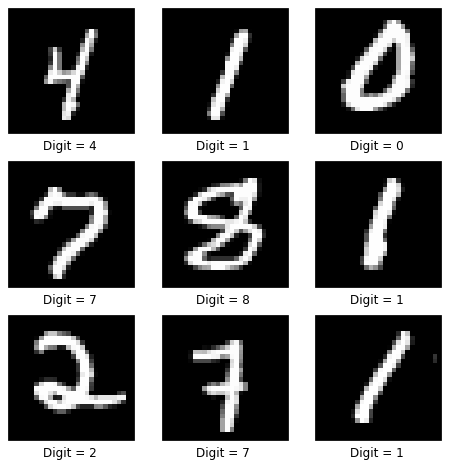

In [11]:
# View some examples from the dataset
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for i, (elem, ax) in enumerate(zip(datasets['train'], axes.flat)):
    image = tf.squeeze(elem['image'])
    # print(image)
    label = elem['label']

    ax.imshow(image, cmap='gray')
    ax.text(0.7, -0.12, f'Digit = {label}', ha='right',
            transform=ax.transAxes, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    # plt.show()

In [12]:
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    image = tf.where(image > .5, 1.0, 0.0)
    return image

def _preprocess_label(sample):
    label = tf.cast(sample['label'], tf.int32)
    return label

In [13]:
mn_train_dataset = (datasets['train']
                    .map(_preprocess)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.experimental.AUTOTUNE)
                    .shuffle(int(10e3))
                    )

mn_test_dataset = (datasets['test']
                   .map(_preprocess)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.experimental.AUTOTUNE)
                   )

mn_test_label = (datasets['test']
                 .map(_preprocess_label)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 )

In [14]:
mn_train_dataset, mn_test_dataset, mn_test_label

(<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <PrefetchDataset shapes: (None,), types: tf.int32>)

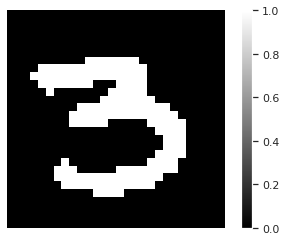

In [15]:
for train_batch in mn_train_dataset.take(1):
    image = train_batch[0].numpy()
image = np.squeeze(image, axis=2)

plt.figure()
plt.imshow(image, cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

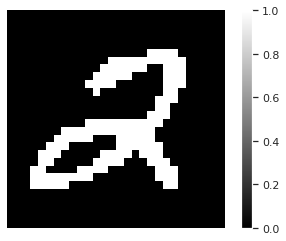

In [16]:
for test_batch in mn_test_dataset.take(1):
    image = test_batch[0].numpy()
image = np.squeeze(image, axis=2)

plt.figure()
plt.imshow(image, cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

In [17]:
for test_label in mn_test_label.take(1):
    label = test_label[0]
label.numpy()

2

##### **2b) Fashion MNIST Data**

In [18]:
datasets, datasets_info = tfds.load(name='fashion_mnist',
                                    with_info=True,
                                    as_supervised=False
                                    )

In [19]:
def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    # image = tf.where(image > .5, 1.0, 0.0)
    return image

In [20]:
fm_train_dataset = (datasets['train']
                    .map(_preprocess)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.experimental.AUTOTUNE)
                   .shuffle(60000)
                   )

fm_test_dataset = (datasets['test']
                  .map(_preprocess)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE)
                  )


fm_test_label = (datasets['test']
                 .map(_preprocess_label)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 )

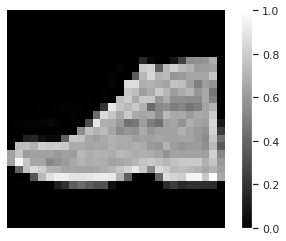

In [21]:
for train_batch in fm_train_dataset.take(1):
    image = train_batch[0].numpy()
image = np.squeeze(image, axis=2)

plt.figure()
plt.imshow(image, cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

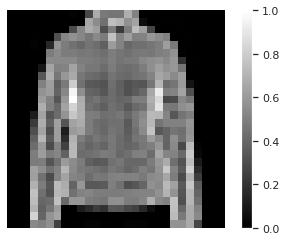

In [22]:
for test_batch in fm_test_dataset.take(1):
    image = test_batch[0].numpy()
image = np.squeeze(image, axis=2)

plt.figure()
plt.imshow(image, cmap='gray')
# plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.axis('off')
plt.show();

In [23]:
for test_label in fm_test_label.take(1):
    label = test_label[0]
label.numpy()

4

Label-clothe item mapping:

In [24]:
'''
0	T-shirt/top
1	Trouser
2	Pullover
3	Dress
4	Coat
5	Sandal
6	Shirt
7	Sneaker
8	Bag
9	Ankle boot
'''

'\n0\tT-shirt/top\n1\tTrouser\n2\tPullover\n3\tDress\n4\tCoat\n5\tSandal\n6\tShirt\n7\tSneaker\n8\tBag\n9\tAnkle boot\n'

#### **3) Model Class**

Credit: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

In [25]:
from tensorflow.keras import layers as tfkl

In [26]:
class Sampler_Z(tfkl.Layer):

    def call(self, inputs):
        mean, logvar = inputs
        # Reparameterize
        eps = tf.random.normal(shape=mean.shape)
        z_sample = eps * tf.exp(logvar * .5) + mean
        return z_sample

In [27]:
# Encoder/Decoder layers 1
class EncoderZ_1(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="encoder", **kwargs):
        super(EncoderZ_1, self).__init__(name=name, **kwargs)
        self.conv_layer_1 = tfkl.Conv2D(filters=n_filter_base,
                                        kernel_size=3,
                                        strides=(2, 2),
                                        padding='valid',
                                        activation='relu'
                                        )
        self.conv_layer_2 = tfkl.Conv2D(filters=n_filter_base*2,
                                        kernel_size=3,
                                        strides=(2, 2),
                                        padding='valid',
                                        activation='relu'
                                        )
        self.flatten_layer = Flatten()
        # No activation
        self.dense_mean = Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(latent_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.conv_layer_2(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_1(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_1, self).__init__(name=name, **kwargs)
        # For MNIST / Fashion MNIST images
        self.dense_z_input = tfkl.Dense(units=7*7*n_filter_base*2,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        # self.dense_z_input = tfkl.Dense(units=56*56*n_filter_base*2,
        #                                 activation=tf.nn.relu
        #                                 )
        # self.reshape_layer = tfkl.Reshape(target_shape=(56, 56, n_filter_base*2))
        self.conv_transpose_layer_1 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           activation='relu'
                                                           )
        self.conv_transpose_layer_2 = tfkl.Conv2DTranspose(filters=n_filter_base,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           activation='relu'
                                                           )
        # No activation
        # For MNIST / Fashion MNIST images
        self.conv_transpose_layer_3 = tfkl.Conv2DTranspose(filters=1,
                                                           kernel_size=3,
                                                           strides=1,
                                                           padding='same'
                                                           )
        # For 0xflower images
        # self.conv_transpose_layer_3 = Conv2DTranspose(filters=3,
        #                                               kernel_size=3,
        #                                               strides=1,
        #                                               padding='same'
        #                                               )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        return x_output

In [28]:
# Encoder/Decoder layers 2
class EncoderZ_2(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="encoder", **kwargs):
        super(EncoderZ_2, self).__init__(name=name, **kwargs)
        self.conv_layer_1 = Conv2D(filters=n_filter_base, kernel_size=5,
                                   strides=1, padding='same', activation=tf.nn.leaky_relu
                                   )
        self.conv_layer_2 = Conv2D(filters=n_filter_base, kernel_size=5,
                                   strides=1, padding='same', activation=tf.nn.leaky_relu
                                   )
        self.conv_layer_3 = Conv2D(filters=n_filter_base, kernel_size=5,
                                   strides=1, padding='same', activation=tf.nn.leaky_relu
                                   )
        self.conv_layer_4 = Conv2D(filters=n_filter_base*2, kernel_size=5,
                                   strides=1, padding='same', activation=tf.nn.leaky_relu
                                   )
        self.conv_layer_5 = Conv2D(filters=n_filter_base*2, kernel_size=5,
                                   strides=1, padding='same', activation=tf.nn.leaky_relu
                                   )
        self.conv_layer_6 = Conv2D(filters=n_filter_base*4, kernel_size=7,
                                   strides=1, padding='same', activation=tf.nn.leaky_relu
                                   )
        self.flatten_layer = Flatten()
        # No activation
        self.dense_mean = Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(latent_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.conv_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.conv_layer_5(z)
        z = self.conv_layer_6(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_2(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_2, self).__init__(name=name, **kwargs)
        # For MNIST / Fashion MNIST images
        self.dense_z_input = tfkl.Dense(units=28*28*n_filter_base*4,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(28, 28, n_filter_base*4))
        # For 0xflower images
        # self.dense_z_input = tfkl.Dense(units=224*224*n_filter_base*4,
        #                                 activation=tf.nn.relu
        #                                 )
        # self.reshape_layer = tfkl.Reshape(target_shape=(224, 224, n_filter_base*4))
        self.conv_transpose_layer_1 = Conv2DTranspose(filters=n_filter_base*4, kernel_size=7,
                                                      strides=1, padding='same', activation=tf.nn.leaky_relu
                                                      )
        self.conv_transpose_layer_2 = Conv2DTranspose(filters=n_filter_base*2, kernel_size=5,
                                                      strides=1, padding='same', activation=tf.nn.leaky_relu
                                                      )
        self.conv_transpose_layer_3 = Conv2DTranspose(filters=n_filter_base*2, kernel_size=5,
                                                      strides=1, padding='same', activation=tf.nn.leaky_relu
                                                      )
        self.conv_transpose_layer_4 = Conv2DTranspose(filters=n_filter_base, kernel_size=5,
                                                      strides=1, padding='same', activation=tf.nn.leaky_relu
                                                      )
        self.conv_transpose_layer_5 = Conv2DTranspose(filters=n_filter_base, kernel_size=5,
                                                      strides=1, padding='same', activation=tf.nn.leaky_relu
                                                      )
        self.conv_transpose_layer_6 = Conv2DTranspose(filters=n_filter_base, kernel_size=5,
                                                      strides=1, padding='same', activation=tf.nn.leaky_relu
                                                      )
        # For MNIST / Fashion MNIST images
        self.conv_transpose_layer_7 = Conv2DTranspose(filters=1, kernel_size=5,
                                                      strides=1, padding='same'
                                                      )
        # For 0xflower images
        # self.conv_transpose_layer_7 = Conv2DTranspose(filters=3, kernel_size=5,
        #                                               strides=1, padding='same'
        #                                               )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        x_output = self.conv_transpose_layer_5(x_output)
        x_output = self.conv_transpose_layer_6(x_output)
        x_output = self.conv_transpose_layer_7(x_output)
        return x_output

In [62]:
# Encoder/Decoder layers 3 (Fashion MNIST)
class EncoderZ_3(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="encoder", **kwargs):
        super(EncoderZ_3, self).__init__(name=name, **kwargs)
        # Block-1
        self.conv_layer_1 = tfkl.Conv2D(filters=n_filter_base, kernel_size=3,
                                        strides=1, padding='same', name='conv_1'
                                        )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_layer_2 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_2'
                                        )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_layer_3 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=2, padding='same', name='conv_3'
                                        )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        self.conv_layer_4 = tfkl.Conv2D(filters=n_filter_base*2, kernel_size=3,
                                        strides=1, padding='same', name='conv_4'
                                        )
        self.batch_layer_4 = tfkl.BatchNormalization(name='bn_4')
        self.activation_layer_4 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_4')
        # Final Block
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(latent_dim, activation=None, name='z_mean')
        self.dense_raw_stddev = Dense(latent_dim, activation=None,
                                      name='z_raw_stddev'
                                      )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.batch_layer_1(z)
        z = self.activation_layer_1(z)
        z = self.conv_layer_2(z)
        z = self.batch_layer_2(z)
        z = self.activation_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.batch_layer_3(z)
        z = self.activation_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.batch_layer_4(z)
        z = self.activation_layer_4(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar


class DecoderX_3(tfkl.Layer):

    def __init__(self, latent_dim, n_filter_base, name="decoder", **kwargs):
        super(DecoderX_3, self).__init__(name=name, **kwargs)
        # For MNIST / Fashion MNIST images
        self.dense_z_input = tfkl.Dense(units=7*7*n_filter_base*2,
                                        activation=tf.nn.relu
                                        )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        # For 0xflower images
        # self.dense_z_input = tfkl.Dense(units=56*56*n_filter_base*2,
        #                                 activation=tf.nn.relu
        #                                 )
        # self.reshape_layer = tfkl.Reshape(target_shape=(56, 56, n_filter_base*2))
        # Block-1
        self.conv_transpose_layer_1 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_1'
                                                           )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1')
        self.activation_layer_1 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_1')
        # Block-2
        self.conv_transpose_layer_2 = tfkl.Conv2DTranspose(filters=n_filter_base*2,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_2'
                                                           )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2')
        self.activation_layer_2 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_2')
        # Block-3
        self.conv_transpose_layer_3 = tfkl.Conv2DTranspose(filters=n_filter_base,
                                                           kernel_size=3,
                                                           strides=2, 
                                                           padding='same',
                                                           name='conv_transpose_3'
                                                           )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3')
        self.activation_layer_3 = tfkl.Activation(tf.nn.leaky_relu, name='lrelu_3')
        # Block-4
        # For MNIST / Fashion MNIST images
        self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=1,
                                                           kernel_size=3,
                                                           strides=1, 
                                                           padding='same',
                                                           name='conv_transpose_4'
                                                           )
        # For 0xflower images
        # self.conv_transpose_layer_4 = tfkl.Conv2DTranspose(filters=3,
        #                                                    kernel_size=3,
        #                                                    strides=1, 
        #                                                    padding='same',
        #                                                    name='conv_transpose_4'
        #                                                    )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.batch_layer_1(x_output)
        x_output = self.activation_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.batch_layer_2(x_output)
        x_output = self.activation_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.batch_layer_3(x_output)
        x_output = self.activation_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        return x_output

In [63]:
class VAEModel(tfk.Model):
    """Convolutional variational autoencoder base model."""

    def __init__(self, latent_dim, n_filter_base):
        super(VAEModel, self).__init__()
        self.encoder = EncoderZ_3(latent_dim, n_filter_base)
        self.decoder = DecoderX_3(latent_dim, n_filter_base)

    @tf.function
    def sample(self, z_sample):
        # z_sample, _, _ = self.encoder(x_sample)
        x_recons_logits = self.decoder(z_sample)
        sample_images = tf.sigmoid(x_recons_logits)  # predictions
        # sample_images = tf.math.sigmoid(x_recons_logits)  # predictions
        return sample_images

    def call(self, x_input):
        z_sample, mean, logvar = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        return x_recons_logits, z_sample, mean, logvar


In [87]:
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, image_dim, z_dim, n_filter_base=32, learning_rate=0.0005):
        self.optimizer = tfk.optimizers.Adam(learning_rate)
        self.model = VAEModel(z_dim, n_filter_base)
        self.metrics = defaultdict(list)

    def train(self, train_dataset, test_dataset, test_label, batch_size=0, 
              n_epoch=10, n_sample=4):
        # Pick a sample of the test set for generating output images
        # num_examples_to_generate = n_sample
        assert batch_size >= n_sample
        for test_batch, test_batch_label in zip(test_dataset.take(1),
                                                test_label.take(1)
                                                ):
            test_sample = test_batch[0:n_sample, :, :, :]
            test_sample_label = test_batch_label[0:n_sample]

        # self.generate_and_save_images(0, test_sample)
        for epoch in range(1, n_epoch + 1):
            start_time = time.time()
            for train_x in tqdm(train_dataset):
                self.train_step(train_x)
            end_time = time.time()

            loss = tfk.metrics.Mean()
            for test_x in test_dataset:
                loss(self.compute_loss(test_x))
            elbo = -loss.result()
            display.clear_output(wait=False)
            # print(f"Epoch: {epoch}, Test set ELBO: {elbo}, Test set KL-Divergence: " + \
            #       f"time elapse for current epoch: {end_time - start_time}"
            #       .format(epoch, elbo, )
            #       )
            print("Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}"
                  .format(epoch, elbo, end_time - start_time)
                  )
            # [KC]: Problem 2
            self.metrics['loss'].append(loss.result().numpy())
            self.metrics['elbo'].append(elbo.numpy())
            if n_sample <= 16:
                self.generate_and_save_images(epoch, test_sample)
            self.plot_label_clusters(test_sample, test_sample_label)

    @tf.function
    def train_step(self, x_true):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x_true)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def compute_loss(self, x_true):
        x_recons_logits, z_sample, mean, logvar = self.model(x_true)
        # Cross Entropy Loss 
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recons_logits,
                                                            labels=x_true
                                                            )
        # Negative Log-Likelihood
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        neg_ll = logpx_z
        # KL-Divergence
        logpz = self.log_normal_pdf(z_sample, 0., 1.)
        logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
        kl_div = logqz_x - logpz
        # [KC]: Problem 2
        # ELBO
        # kl_div_mean = tf.math.reduce_mean(kl_div)
        # neg_ll_mean = tf.math.reduce_mean(neg_ll)
        # elbo = -kl_div_mean + neg_ll_mean
        # loss = -elbo
        elbo = tf.math.reduce_mean(-kl_div + neg_ll)
        # ipdb.set_trace()
        return -elbo
        # return loss, elbo, kl_div, neg_ll

    def generate_and_save_images(self, epoch, test_sample):
        z_sample, _, _ = self.model.encoder(test_sample)
        decoder_sample_images = self.model.sample(z_sample)  # predictions
        fig = plt.figure(figsize=(4, 4))
        for i in range(decoder_sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(decoder_sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show();

    def plot_label_clusters(self, test_sample, test_sample_label):
        # display a 2D plot of the digit classes in the latent space
        z_sample, _, _ = self.model.encoder(test_sample)
        colors = ['pink', 'red', 'orange', 'yellow', 'green',
                  'blue', 'purple', 'brown', 'gray', 'black'
                  ]
        plt.figure(figsize=(4, 4))
        plt.scatter(z_sample[:, 0], z_sample[:, 1], c=test_sample_label,
                    cmap=matplotlib.colors.ListedColormap(colors)
                    )
        plt.colorbar()
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.show();


#### **4) Models Train**

In [88]:
mn_train_dataset, fm_train_dataset

(<ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>,
 <ShuffleDataset shapes: (None, 28, 28, 1), types: tf.float32>)

In [95]:
# vae init params
input_dim = 28  # image dim
image_dim = (28, 28, 1)
# image_dim = (224, 224, 3)
z_dim = 2  # latent dim, set the dimensionality of the latent space to a plane for visualization later
n_filter_base = 32  # number of base filters in the CNN (a lot of filters?)
learning_rate = 0.0005  # uses for the internal Adam opt

# vae.train params
# [KC]: Problem 1
n_epoch = 10  # number of epochs
batch_size = BATCH_SIZE
show_display = True
display_sample = False
n_sample = 16  #16  # number of example outputs to sample and generate, also n_display

In [96]:
vae = VAE(image_dim, z_dim)

Epoch: 10, Test set ELBO: -264.9119873046875, time elapse for current epoch: 5.279751300811768


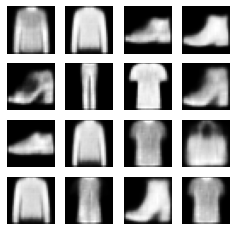

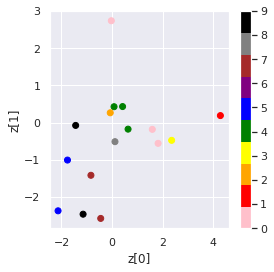

CPU times: user 1min 25s, sys: 10.7 s, total: 1min 36s
Wall time: 1min 33s


In [97]:
%%time
vae.train(fm_train_dataset,
          fm_test_dataset,
          fm_test_label,
          batch_size,
          n_epoch,
          n_sample
          )

#### **5) Models Display**

In [98]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

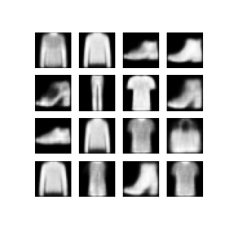

In [99]:
plt.imshow(display_image(n_epoch))
plt.axis('off')  # Display images

In [100]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


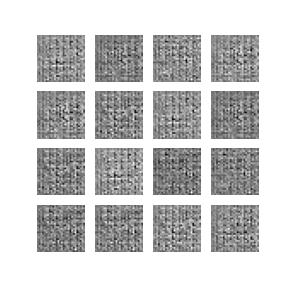

In [101]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [102]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

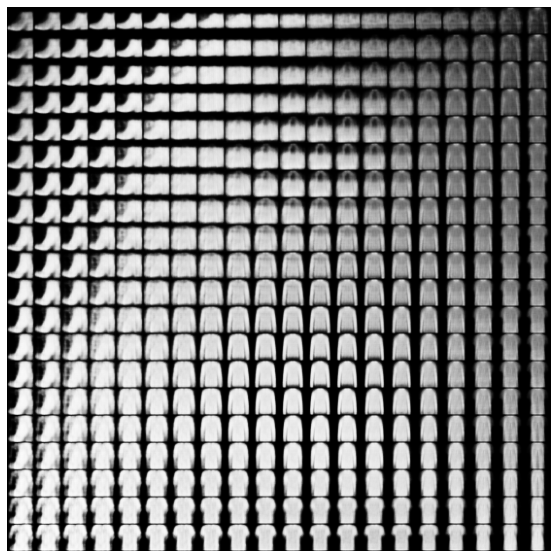

In [103]:
plot_latent_images(vae.model, 20)

Summarize history for loss

In [104]:
vae.metrics['loss']

[280.33395,
 274.7761,
 270.86856,
 269.1157,
 267.8946,
 267.04486,
 266.30096,
 265.73682,
 265.64423,
 264.912]

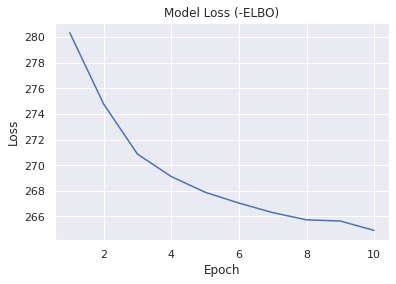

In [105]:
plt.plot(range(1, n_epoch+1), vae.metrics['loss'])
plt.title('Model Loss (-ELBO)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.show();

Summarize history for ELBO

In [106]:
vae.metrics['elbo']

[-280.33395,
 -274.7761,
 -270.86856,
 -269.1157,
 -267.8946,
 -267.04486,
 -266.30096,
 -265.73682,
 -265.64423,
 -264.912]

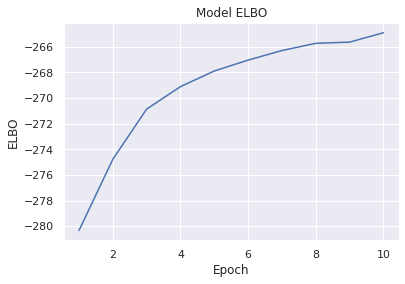

In [107]:
plt.plot(range(1, n_epoch+1), vae.metrics['elbo'])
plt.title('Model ELBO')
plt.ylabel('ELBO')
plt.xlabel('Epoch')
# plt.ylim(ymin=0)
plt.show();

In [ ]:
# [KC]: Problem 3